1
||Γ|| =  64.31201200587455
2
||Γ|| =  53.90257028341164
3
||Γ|| =  36.424492858745936
4
||Γ|| =  11.78786352342082


<IPython.core.display.Javascript object>


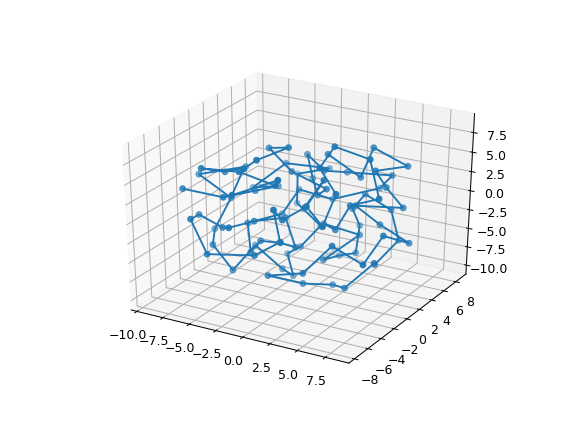

||Γ|| =  11.738029405932908


In [1]:
%matplotlib notebook

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import moment
import scipy as sp

#Polymer Constants

alpha = 110
beta = 128
Na = 80
Nb = 20
la = 3.7 
lb = 2.1 
Ntot = Na + Nb

#Physical constants
gamma=1 #Friction coefficient
ma = 1; mb = 1 #Mass of each object
T = 1 #Temperature of system
ep = 5 #Size of Lennard-Jones well
Kconst = 16.67*ep/(la**2+lb**2)*2 #Harmonic oscillator coefficients

#Time step constants
tsteps = 10000 #Number of time steps to perform where coordinates will not be saved in between
ntsteps = 5 #Number of tsteps to perform, coordinates are saved for each of these
dt = .01 #Size of time step in ~units of harmonic oscillator period

## Editing after this point may cause issues

a_order=np.zeros(Ntot)
a_order[np.argsort(np.random.rand(Ntot))[0:Na]] = 1
radii = a_order*(la-lb)+lb
distances = (radii[0:-1]+radii[1:])/2 #Optimal monomer-monomer distance is average diameter of the two
ms = a_order*(ma-mb)+mb
coords=np.zeros((3,Ntot,tsteps))
grandcoords=np.zeros((3,Ntot,ntsteps))
initrad = (np.sum(distances)+la)/(2*np.pi)
initangles = np.cumsum(2*np.arcsin(distances/(2*initrad)))
coords[1,0,0] = initrad
coords[0,1:,0] = np.sin(initangles)*initrad 
coords[1,1:,0] = np.cos(initangles)*initrad
coords[:,:,0] = [coords[i,:,0]-np.mean(coords[i,:,0]) for i in range(3)]
acc=np.zeros((3,Ntot))
v=np.zeros((3,Ntot))

def calculateLJforces(pos,ep,Kconst,avals,radvals):
    nps = np.shape(pos)[1]
    forces = np.zeros(np.shape(pos))
    for k in range(nps):
        if k == 0:
            Fharmonic = -2*Kconst*(np.linalg.norm(pos[:,k]-pos[:,k+1])-avals[k])*(pos[:,k]-pos[:,k+1])/np.linalg.norm(pos[:,k]-pos[:,k+1])
        elif k == nps-1:
            Fharmonic = -2*Kconst*(np.linalg.norm(pos[:,k-1]-pos[:,k])-avals[k-1])*(pos[:,k]-pos[:,k-1])/np.linalg.norm(pos[:,k-1]-pos[:,k])
        else:
            Fharmonic = -2*Kconst*(np.linalg.norm(pos[:,k]-pos[:,k+1])-avals[k])*(pos[:,k]-pos[:,k+1])/np.linalg.norm(pos[:,k]-pos[:,k+1])-2*Kconst*(np.linalg.norm(pos[:,k-1]-pos[:,k])-avals[k-1])*(pos[:,k]-pos[:,k-1])/np.linalg.norm(pos[:,k-1]-pos[:,k])
        FLJ = np.zeros(3)
        for l in range(nps):
            if k != l:
                rkl = (pos[:,l]-pos[:,k])
                rklmag = np.linalg.norm(pos[:,l]-pos[:,k])
                FLJ = FLJ - 12*ep*(((radvals[k]+radvals[l])/2)**12/rklmag**13-((radvals[k]+radvals[l])/2)**6/rklmag**7)*rkl/rklmag
       
        forces[:,k]=Fharmonic+FLJ
    return forces


    
for j in range(1,tsteps):
    coords[:,:,j]=coords[:,:,j-1]+v*dt+0.5*acc*dt**2
    coords[:,:,j] = [coords[i,:,j]-np.mean(coords[i,:,j]) for i in range(3)] #Center of mass is recentered
    accnew = calculateLJforces(coords[:,:,j],ep,Kconst,distances,radii)/ms+(6*ms*gamma*T/dt)**0.5/ms*np.random.randn(3,Ntot)-gamma*v
    v = v + (acc+accnew)/2*dt
    acc = accnew

    if np.max(coords[:,:,j]) > initrad*1000:
        break
grandcoords[:,:,0] = coords[:,:,-1]

for k in range(1,ntsteps):
    print(k)
    print('||\u0393|| = ',np.linalg.norm(coords[:,-1,-1]-coords[:,0,-1]))
    coords[:,:,0] = coords[:,:,-1]
    for j in range(1,tsteps):
        coords[:,:,j]=coords[:,:,j-1]+v*dt+0.5*acc*dt**2
        coords[:,:,j] = [coords[i,:,j]-np.mean(coords[i,:,j]) for i in range(3)] #Center of mass is recentered
        accnew = calculateLJforces(coords[:,:,j],ep,Kconst,distances,radii)/ms+(6*ms*gamma*T/dt)**0.5/ms*np.random.randn(3,Ntot)-gamma*v
        v = v + (acc+accnew)/2*dt
        acc = accnew

    if np.max(coords[:,:,j]) > initrad*1000:
        print('Unstable results')
        break
    grandcoords[:,:,k] = coords[:,:,-1]
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(coords[0,:,j],coords[1,:,j],coords[2,:,j])
ax.scatter3D(coords[0,:,j],coords[1,:,j],coords[2,:,j])
print('||\u0393|| = ',np.linalg.norm(coords[:,-1,j]-coords[:,0,j]))

<IPython.core.display.Javascript object>


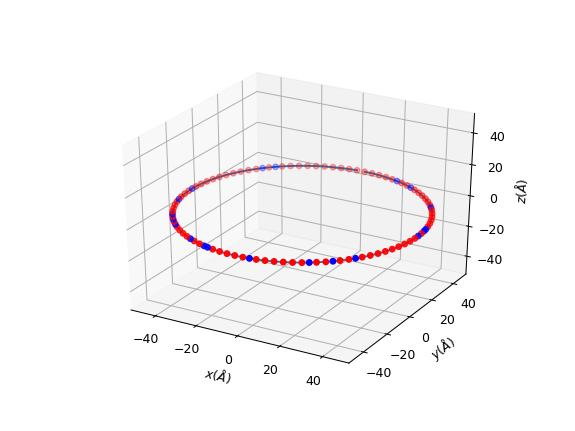

||Γ|| =  3.6418789701783516


<IPython.core.display.Javascript object>


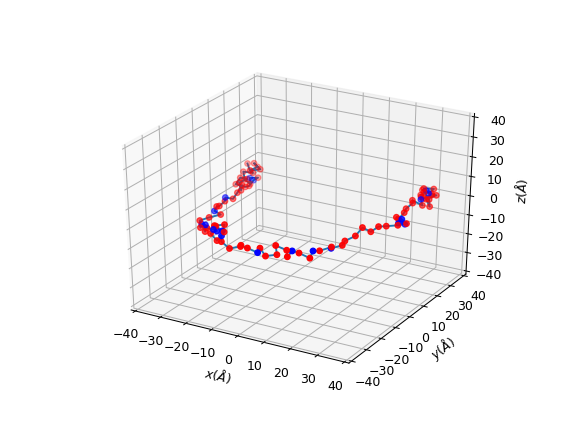

||Γ|| =  64.31201200587455


<IPython.core.display.Javascript object>


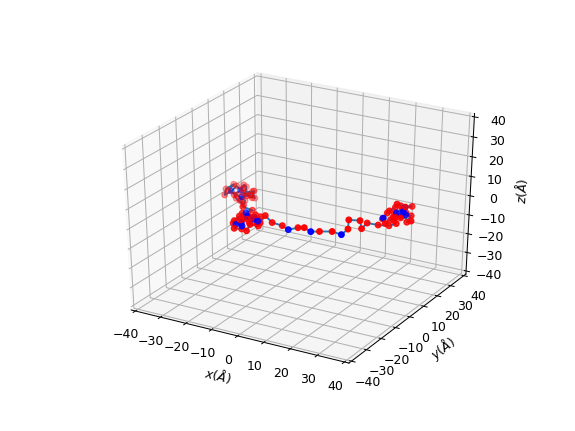

||Γ|| =  53.90257028341164


<IPython.core.display.Javascript object>


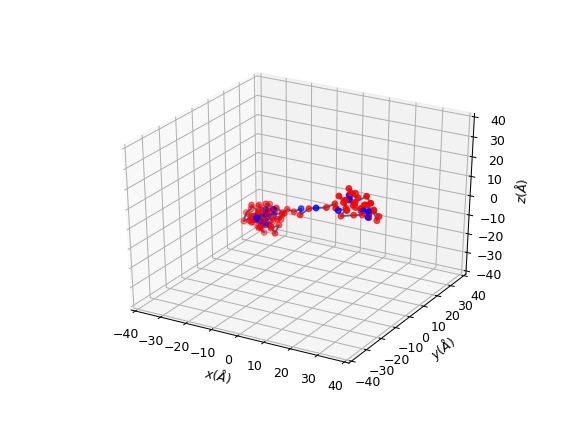

||Γ|| =  36.424492858745936


<IPython.core.display.Javascript object>


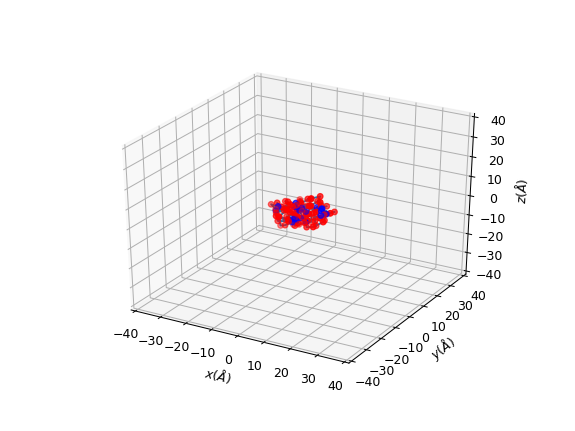

||Γ|| =  11.78786352342082


<IPython.core.display.Javascript object>


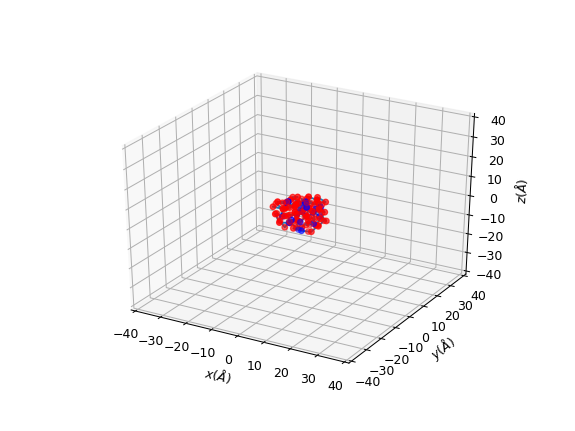

||Γ|| =  11.738029405932908


In [2]:
initcoords = np.zeros((3,Ntot))
initcoords[1,0] = initrad
initcoords[0,1:] = np.sin(initangles)*initrad 
initcoords[1,1:] = np.cos(initangles)*initrad
initcoords[:,:] = [initcoords[i,:]-np.mean(initcoords[i,:]) for i in range(3)]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(initcoords[0,:],initcoords[1,:],initcoords[2,:])
ax.set_xlim(-50,50)
ax.set_ylim(-50,50)
ax.set_zlim(-50,50)
ax.set_xlabel(r'$x (\AA)$', fontsize=10)
ax.set_ylabel(r'$y (\AA)$', fontsize=10)
ax.set_zlabel(r'$z (\AA)$', fontsize=10)
corder=['r' if a_order[i] == 1 else 'b' for i in range(Ntot)]
ax.scatter3D(initcoords[0,:],initcoords[1,:],initcoords[2,:],c=corder)
print('||\u0393|| = ',np.linalg.norm(initcoords[:,-1]-initcoords[:,0]))

for j in range(ntsteps):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot3D(grandcoords[0,:,j],grandcoords[1,:,j],grandcoords[2,:,j])
    ax.set_xlim(-40,40)
    ax.set_ylim(-40,40)
    ax.set_zlim(-40,40)
    ax.set_xlabel(r'$x (\AA)$', fontsize=10)
    ax.set_ylabel(r'$y (\AA)$', fontsize=10)
    ax.set_zlabel(r'$z (\AA)$', fontsize=10)
    corder=['r' if a_order[i] == 1 else 'b' for i in range(Ntot)]
    ax.scatter3D(grandcoords[0,:,j],grandcoords[1,:,j],grandcoords[2,:,j],c=corder)
    print('||\u0393|| = ',np.linalg.norm(grandcoords[:,-1,j]-grandcoords[:,0,j]))